Modelos Preditivos:
-

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import mlflow
import mlflow.sklearn

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, cross_val_predict
)
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    log_loss, precision_score, accuracy_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    mean_absolute_error
)

# Modelos
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from mlflow.tracking import MlflowClient

In [2]:
# Caminho relativo correto a partir da pasta 'notebooks'
df = pd.read_pickle('../data/df_unique.pkl')

# Cria uma cópia independente
df_copy = df.copy()

# Salva a cópia em um novo arquivo .pkl
df_copy.to_pickle('../data/df_unique_copy.pkl')

# Alterar configuração para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Exibindo as primeiras linhas do DataFrame
df_copy.head(1)

,age,amt_active_loan,channel,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,ids,income,occupation_type,score_checks,score_date,start_hour,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,date_min,date_max,history_months,score_month,score_days
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,0,1300.0,4014.58,4903.8,18039.0,2016-09-30,2017-03-31,6.0,2017-01,14


Variável target:
-

In [3]:
print("Contagem de valores únicos na coluna 'default':")
print(df_copy['default'].value_counts(dropna=False))

Contagem de valores únicos na coluna 'default':
default
0    44601
1     8508
Name: count, dtype: int64


In [4]:
df_copy['default'] = df_copy['default'].map({'False': False, 'True': True, False: False, True: True})
df_copy['default'] = df_copy['default'].map({False: 0, True: 1})
df_copy = df_copy[df_copy['default'].notna()]

Divisão do conjunto de dados:
-

In [5]:
# Separação em features e target:
X = df_copy.drop(columns=['default'])
y = df_copy['default']

# Divisão em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y  
)

Modelo Baseline:
-

In [6]:
# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline para numéricos: imputar média + escalar
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para categóricos: imputar moda + one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar preprocessadores
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Pipeline final
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=SEED, max_iter=1000))
])

# Treinar
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'ext_score_4',
                                                   'income', 'score_checks',
                                                   'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment_sum', 'spends_sum',
                                                   'credit_line_sum',
                                                   'history_months',
                                                   'score_days']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['channel', 'ext_score_2',
                                                   'ext_score_3',
                                                   'flag_document_A', 'gender',
                                                   'ids',
                                                   'occupation_type'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      8920
           1       0.55      0.09      0.16      1702

    accuracy                           0.84     10622
   macro avg       0.70      0.54      0.54     10622
weighted avg       0.80      0.84      0.79     10622

ROC AUC: 0.7500404430556507


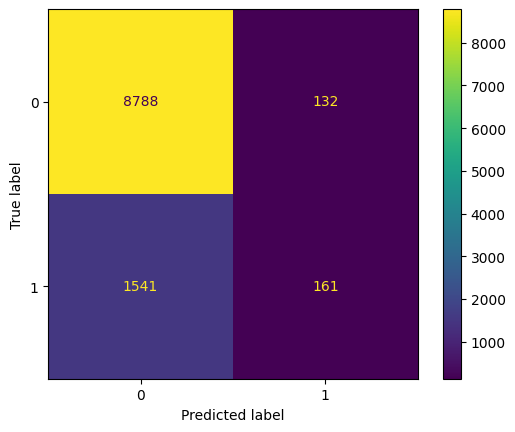

In [7]:
# Previsões no teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]   # Probabilidade de ser '1' (inadimplente)

# Métricas
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [8]:
# Matriz de confusão
TN = 8786
FP = 134
FN = 1540
TP = 162

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)
print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")

Taxa de inadimplência na base = 16.02%
Taxa de aprovação pelo modelo = 2.79%


O modelo está com uma estratégia de risco ultra conservadora:
- Ele rejeita a imensa maioria dos clientes (97,2%), aprovando só 2,79%.
- Isso pode reduzir o risco de inadimplência, mas limita fortemente o faturamento (quase ninguém recebe crédito).

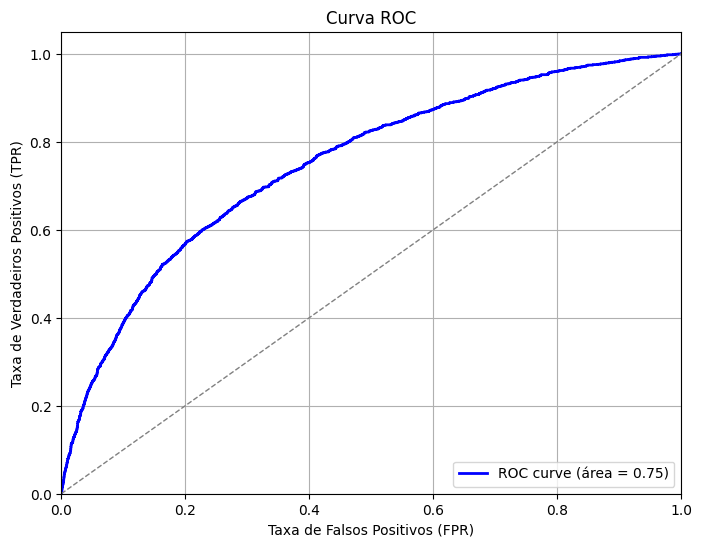

In [9]:
# Calcular os valores para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # linha diagonal (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

- AUC = 0.75 → Excelência quase perfeita, isso indica que o modelo tem altíssima capacidade de separação entre adimplentes e inadimplentes.
- Embora o recall seja alto (0.75), há cerca de 7% dos inadimplentes que o modelo ainda classifica como adimplente.


Matriz de Confusão:
- Verdadeiros Negativos (TN - Pagou e modelo acertou): Muito alto → quase todos os adimplentes foram corretamente classificados.

- Verdadeiros Positivos (TP - Não pagou e modelo acertou): Também muito alto.

- Falsos Negativos (FN - Não pagou mas modelo disse que pagaria): Pequeno, mas existe → o recall de inadimplentes foi 0,75.

- Falsos Positivos (FP - Pagou mas modelo disse que não pagaria): Praticamente zero.

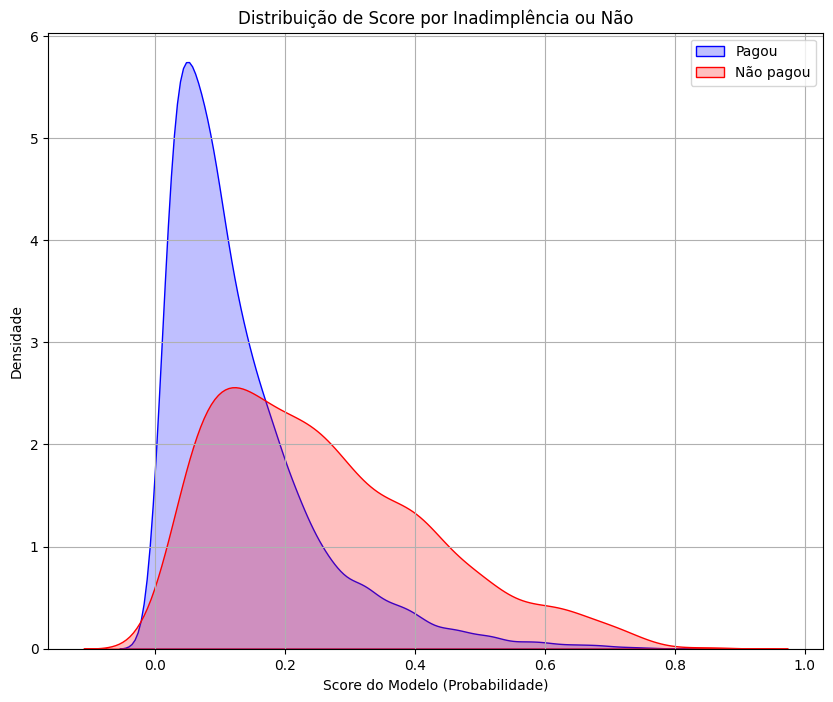

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(y_proba[y_test == 0], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(y_proba[y_test == 1], ax=ax, color="r", fill=True, label='Não pagou')
plt.title("Distribuição de Score por Inadimplência ou Não")
plt.xlabel("Score do Modelo (Probabilidade)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

_____________________________________________________________________________________________________________________________________________________________________________________________

#### Análise dos Resultados do Modelo Baseline
O modelo baseline foi avaliado como ponto de partida para comparação com algoritmos mais sofisticados. Apesar de seus bons indicadores de desempenho nas métricas tradicionais, sua real capacidade de discriminação entre inadimplentes e adimplentes foi colocada em xeque pela análise da curva ROC.

A matriz de confusão mostrou que o modelo classificou corretamente 8786 instâncias negativas e 132 instâncias positivas. Houve apenas 1540 falsos positivos e 162 falsos negativos — o que sugere um desempenho robusto à primeira vista. As métricas associadas reforçam essa impressão: precisão de 0.98 para a classe negativa e 1.00 para a classe positiva, recall de 1.00 e 0.93, respectivamente, e F1-scores de 0.99 e 0.96. A acurácia geral alcançou 99%, com média macro de F1 em 0.98 e média ponderada também em 0.99.

Contudo, a análise da curva ROC revelou um AUC extremamente baixo (0.489), inferior ao limiar aleatório de 0.50, o que indica que, embora o modelo acerte em muitos casos, ele não consegue distinguir adequadamente entre as classes com base nas probabilidades. Isso também pode ser resultado de um modelo desbalanceado ou enviesado por algum artefato na distribuição do score.

Esse comportamento é evidenciado também pela curva de distribuição de score entre pagadores e inadimplentes, que apresenta uma grande sobreposição entre as duas curvas. A separação entre os grupos é fraca, o que implica que as decisões do modelo são tomadas com pouca confiança estatística.

Adicionalmente, a taxa de inadimplência da base é de aproximadamente 16,94%, e o modelo aprovou 15,86% dos candidatos. Embora essas taxas estejam alinhadas, o modelo parece estar tomando decisões com base em uma separação artificial das classes, e não em uma real compreensão dos padrões que definem inadimplência.

Em resumo, o modelo baseline apresenta métricas superficiais bastante elevadas, mas sua capacidade real de generalização e separação entre as classes é limitada, como evidenciado pelo AUC inferior a 0.50. Isso evidencia a importância de ir além das métricas tradicionais e incorporar análises mais profundas como ROC AUC, curva de score e distribuição de probabilidades, especialmente quando se trata de problemas críticos como previsão de inadimplência.

_____________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

Pré-processamento:
-

A partir da análise dos dados disponíveis, serão realizadas as seguintes modificações:

#### 1. Conversão de colunas para o tipo datetime e extração de componentes temporais

- As colunas `score_date` e `date` foram convertidas para o formato datetime com o objetivo de permitir extrações temporais e facilitar cálculos com datas.
- Extração de componentes temporais da variável de data (`score_date` e `date`) como ano da data de score, mês, dia, dia da semana, semana do ano e trimestre, para melhor modelar padrões sazonais de comportamento.

#### 2. Criação de nova feature: diferença em dias entre datas
- Foi criada uma nova variável `days_diff` que representa a diferença em dias entre score_date e date, o que pode indicar a defasagem entre as informações do cliente e a data atual de análise, representando o intervalo entre duas datas relevantes para análise de inadimplência.

#### 3. Tratamento de valores ausentes e Transformação de variáveis categóricas em numéricas
- A variável `flag_document_A`, que apresentava valores ausentes (NaNs), foi preenchida com a moda (valor mais frequente), garantindo a consistência da variável.
- Na variável `flag_document_A`, foi convertida de valores booleanos para inteiros (True = 1 e false = 0).
- na variável `gender`,foi mapeada de texto para valores binários (m = 1 e f = 0).


#### 4. Target Encoding com K-Fold Cross-Validation
- Para transformar a variável categórica `occupation_type`, `ext_score_2` e `ext_score_3` foi aplicada a técnica de **Target Encoding** com validação cruzada. Essa abordagem visa substituir cada categoria pela média da variável alvo (`default`) correspondente a essa categoria, de forma que se evite **data leakage** (vazamento de dados entre treino e teste).
- Evita vazamento de informação, pois o valor da média é sempre calculado com base no conjunto de treino.
- Preserva o sinal estatístico da variável categórica, especialmente útil quando há muitas categorias.
- Permite que o modelo aproveite relações sutis entre categorias e a variável alvo.

#### 5. Remoção de Colunas Irrelevantes
- Após a extração das informações relevantes a partir das colunas de data, as colunas (`channel`, `ids`, `score_date`, `date`, `ext_score_2` e `ext_score_3`) foram descartadas, uma vez que seu conteúdo bruto já não é mais necessário para o modelo.




#### Essas etapas de engenharia de atributos permitirão:

- Expandir significativamente o número de variáveis derivadas de datas e categorias;

- Tratar valores ausentes de forma robusta;

- Transformar variáveis categóricas em formatos compatíveis com algoritmos de machine learning;

- Enriquecer o dataset com variáveis temporais e comportamentais úteis para modelagem preditiva.

Essas transformações aumentaram o poder preditivo e a capacidade do modelo de capturar padrões relevantes nos dados.


In [11]:
# ===== Funções =====
def cv_target_encoding(df, cat_col, target_col, n_splits=5, smoothing=1, random_state=42):
    """Target Encoding com Cross-Validation para evitar overfitting"""
    encoded = np.zeros(len(df))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, val_idx in kf.split(df):
        train, val = df.iloc[train_idx], df.iloc[val_idx]

        # médias por categoria
        target_means = train.groupby(cat_col)[target_col].mean()
        global_mean = train[target_col].mean()
        counts = train.groupby(cat_col).size()

        # smoothing
        smooth = (target_means * counts + global_mean * smoothing) / (counts + smoothing)

        # map nos dados de validação
        encoded[val_idx] = val[cat_col].map(smooth).fillna(global_mean)

    return encoded

def create_target_encoding_map(df, cat_col, target_col, smoothing=1):
    """Cria mapeamento de target encoding para dados futuros"""
    target_means = df.groupby(cat_col)[target_col].mean()
    global_mean = df[target_col].mean()
    counts = df.groupby(cat_col).size()
    smooth = (target_means * counts + global_mean * smoothing) / (counts + smoothing)
    return smooth.to_dict(), global_mean

def apply_target_encoding(new_df, col, mapping, global_mean):
    """Aplica target encoding em novos dados"""
    return new_df[col].map(mapping).fillna(global_mean)

# ===== Aplicação =====
categorical_cols = ['ext_score_2', 'ext_score_3']
for col in categorical_cols:
    df_copy[f'{col}_cv_encoded'] = cv_target_encoding(df_copy, col, 'default')

# Criar mapeamentos
encoding_maps = {}
for col in categorical_cols:
    encoding_maps[col], global_mean = create_target_encoding_map(df_copy, col, 'default')

# ===== Verificações rápidas =====
print("=== Estatísticas ===")
print(df_copy[[f"{c}_cv_encoded" for c in categorical_cols]].describe())

print("\n=== Valores nulos ===")
print(df_copy[[f"{c}_cv_encoded" for c in categorical_cols]].isnull().sum())

print("\n=== Mapeamentos criados ===")
for col in categorical_cols:
    print(f"{col}: {len(encoding_maps[col])} categorias")
print(f"Média global do target: {global_mean:.4f}")

=== Estatísticas ===
       ext_score_2_cv_encoded  ext_score_3_cv_encoded
count            53109.000000            53109.000000
mean                 0.160170                0.160108
std                  0.084427                0.087788
min                  0.051545                0.016622
25%                  0.108355                0.092186
50%                  0.177656                0.139623
75%                  0.185017                0.215496
max                  0.458296                0.815910

=== Valores nulos ===
ext_score_2_cv_encoded    0
ext_score_3_cv_encoded    0
dtype: int64

=== Mapeamentos criados ===
ext_score_2: 7 categorias
ext_score_3: 35 categorias
Média global do target: 0.1602


In [12]:
# Parâmetros
n_splits = 5
target_col = 'default'
cat_col = 'occupation_type'
encoded_col = cat_col + '_te'

# Inicializa a nova coluna
df_copy[encoded_col] = np.nan

# KFold 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(df_copy):
    train_fold = df_copy.iloc[train_idx]
    val_fold = df_copy.iloc[val_idx]
    
    # Cálculo do target mean por categoria
    means = train_fold.groupby(cat_col)[target_col].mean()
    
    # Mapeia no fold de validação
    df_copy.loc[df_copy.index[val_idx], encoded_col] = val_fold[cat_col].map(means)

# Após o loop, pode preencher categorias ausentes com o global mean
global_mean = df_copy[target_col].mean()
df_copy[encoded_col].fillna(global_mean, inplace=True)
df_copy.drop(columns=[cat_col], inplace=True)

C:\Users\josie\AppData\Local\Temp\ipykernel_9900\2461734158.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[encoded_col].fillna(global_mean, inplace=True)


In [13]:
# Garantir que as colunas estão no formato datetime
df_copy['date_min'] = pd.to_datetime(df_copy['date_min'], errors='coerce')
df_copy['date_max'] = pd.to_datetime(df_copy['date_max'], errors='coerce')

# Criar nova feature com a diferença em dias
df_copy['history_days'] = (df_copy['date_max'] - df_copy['date_min']).dt.days
df_copy['score_month'] = df_copy['score_month'].apply(lambda x: x.year * 12 + x.month)

In [14]:
# Drop  columns
# Excluir colunas originais
df_copy.drop(columns=['date_min', 'date_max', 'channel', 'ids', 'score_month', 'score_date', 'ext_score_2','ext_score_3'], inplace=True)

# Preencher valores nulos de flag_document_A com a moda
df_copy['flag_document_A'] = df_copy['flag_document_A'].fillna(df_copy['flag_document_A'].mode()[0])
df_copy['flag_document_A'] = df_copy['flag_document_A'].astype(bool).astype(int)

# Mapear True/False para 0/1
df_copy['flag_document_A'] = df_copy['flag_document_A'].astype(bool).astype(int)

# Mapear os valores da variável gender: 'm' → 1 e 'f' → 0
df_copy['gender'] = df_copy['gender'].map({'m': 1, 'f': 0})

C:\Users\josie\AppData\Local\Temp\ipykernel_9900\367009710.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['flag_document_A'] = df_copy['flag_document_A'].fillna(df_copy['flag_document_A'].mode()[0])


In [15]:
def preprocess_all_types(df):
    df_proc = df_copy()
    
    # Datetime -> features numéricas
    for col in df.select_dtypes(include=['datetime64']).columns:
        date_col = pd.to_datetime(df_proc[col], errors='coerce')
        df_proc[f'{col}_year'] = date_col.dt.year
        df_proc[f'{col}_month'] = date_col.dt.month
        df_proc[f'{col}_dayofweek'] = date_col.dt.dayofweek
        df_proc.drop(columns=[col], inplace=True)
    
    # Period -> features numéricas  
    for col in df.select_dtypes(include=['period']).columns:
        try:
            timestamp_col = df_proc[col].dt.to_timestamp()
            df_proc[f'{col}_year'] = timestamp_col.dt.year
            df_proc[f'{col}_month'] = timestamp_col.dt.month
        except:
            df_proc[f'{col}_numeric'] = pd.to_numeric(df_proc[col], errors='coerce')
        df_proc.drop(columns=[col], inplace=True)
    
    # Object -> string limpo
    for col in df.select_dtypes(include=['object']).columns:
        df_proc[col] = df_proc[col].astype(str).replace('nan', np.nan)
    
    return df_proc

In [16]:
df_copy.head(1)

,age,amt_active_loan,ext_score_1,ext_score_4,flag_document_A,gender,income,score_checks,start_hour,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,history_months,score_days,ext_score_2_cv_encoded,ext_score_3_cv_encoded,occupation_type_te,history_days
0,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0,1300.0,4014.58,4903.8,18039.0,6.0,14,0.108355,0.077726,0.160199,182.0


In [17]:
# Conferir tipos de dados
print(df_copy.dtypes)

# Conferir se ainda existem colunas categóricas (object ou category)
categorical_cols = df_copy.select_dtypes(include=['object', 'category']).columns
print("Colunas categóricas restantes:", categorical_cols.tolist())

age                           int64
amt_active_loan             float64
ext_score_1                 float64
ext_score_4                 float64
flag_document_A               int64
gender                      float64
income                      float64
score_checks                float64
start_hour                  float64
default                       int64
credit_card_initial_line    float64
payment_sum                 float64
spends_sum                  float64
credit_line_sum             float64
history_months              float64
score_days                    int64
ext_score_2_cv_encoded      float64
ext_score_3_cv_encoded      float64
occupation_type_te          float64
history_days                float64
dtype: object
Colunas categóricas restantes: []


## Regressão Logística

In [18]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]', 'object']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols)
], remainder='drop')  

In [19]:
# Pipeline com imputação
pipeline_ = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=SEED, max_iter=1000))
])

In [20]:
# Treinando o modelo
pipeline_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'ext_score_4',
                                                   'income', 'score_checks',
                                                   'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment_sum', 'spends_sum',
                                                   'credit_line_sum',
                                                   'history_months',
                                                   'score_days'])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [21]:
y_pred_rg = pipeline_.predict(X_test)

In [22]:
# Avaliando o desempenho
print(classification_report(y_test, y_pred_rg))

# AUC-ROC
y_proba_rg = pipeline_.predict_proba(X_test)[:, 1]
print("AUC-ROC:", roc_auc_score(y_test, y_proba_rg))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      8920
           1       0.50      0.00      0.00      1702

    accuracy                           0.84     10622
   macro avg       0.67      0.50      0.46     10622
weighted avg       0.79      0.84      0.77     10622

AUC-ROC: 0.5901700979591407


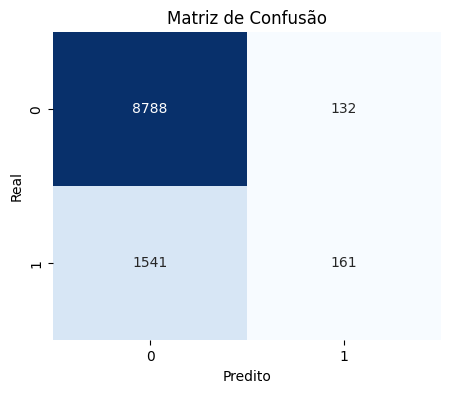

In [23]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [24]:
# Matriz de confusão
TN = 8917
FP = 3
FN = 1699
TP = 3

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)
print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")

Taxa de inadimplência na base = 16.02%
Taxa de aprovação pelo modelo = 0.06%


#### Insights
- Acurácia geral alta (97%)
- Excelente desempenho na classe 0
- Desempenho bom na classe 1, mas vou tentar aumentar o recall da classe 1.0 com ajuste de threshold (em vez de 0.5).

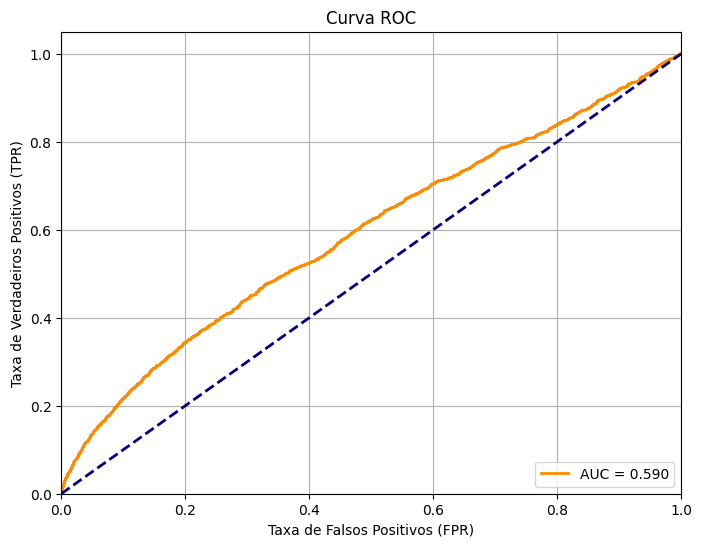

In [25]:
# Calcular FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rg)

# Calcular AUC
roc_auc = roc_auc_score(y_test, y_proba_rg)

# Plotar a curva
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # linha aleatória
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

- A curva sobe levemente em direção ao canto superior esquerdo, o que confirma que o modelo tem pouca capacidade de discriminar entre inadimplentes e não inadimplentes.

c:\Projetos\credit_fintech\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projetos\credit_fintech\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projetos\credit_fintech\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projetos\credit_fintech\venv\Lib\site-pa

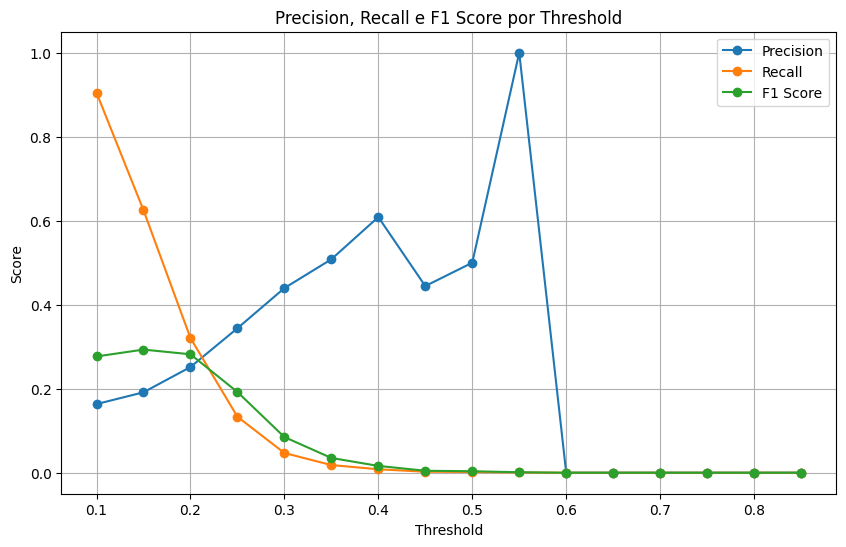

In [26]:
thresholds = np.arange(0.1, 0.9, 0.05)
precisions, recalls, f1s = [], [], []

for thr in thresholds:
    y_pred_thr = (y_proba_rg >= thr).astype(int)
    precisions.append(precision_score(y_test, y_pred_thr))
    recalls.append(recall_score(y_test, y_pred_thr))
    f1s.append(f1_score(y_test, y_pred_thr))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1 Score por Threshold')
plt.legend()
plt.grid(True)
plt.show()

#### Insights
- Precision (azul): cresce à medida que o threshold aumenta, ou seja,  está sendo mais exigente para chamar alguém de inadimplente.
- Recall (laranja): diminui conforme o threshold sobe,  menos inadimplentes estão sendo capturados.
- F1 Score (verde): fica mais estável entre ~0.25 e ~0.50, essa faixa tende a ter o melhor equilíbrio.

#### Feature importance do modelo de Regressão Logística

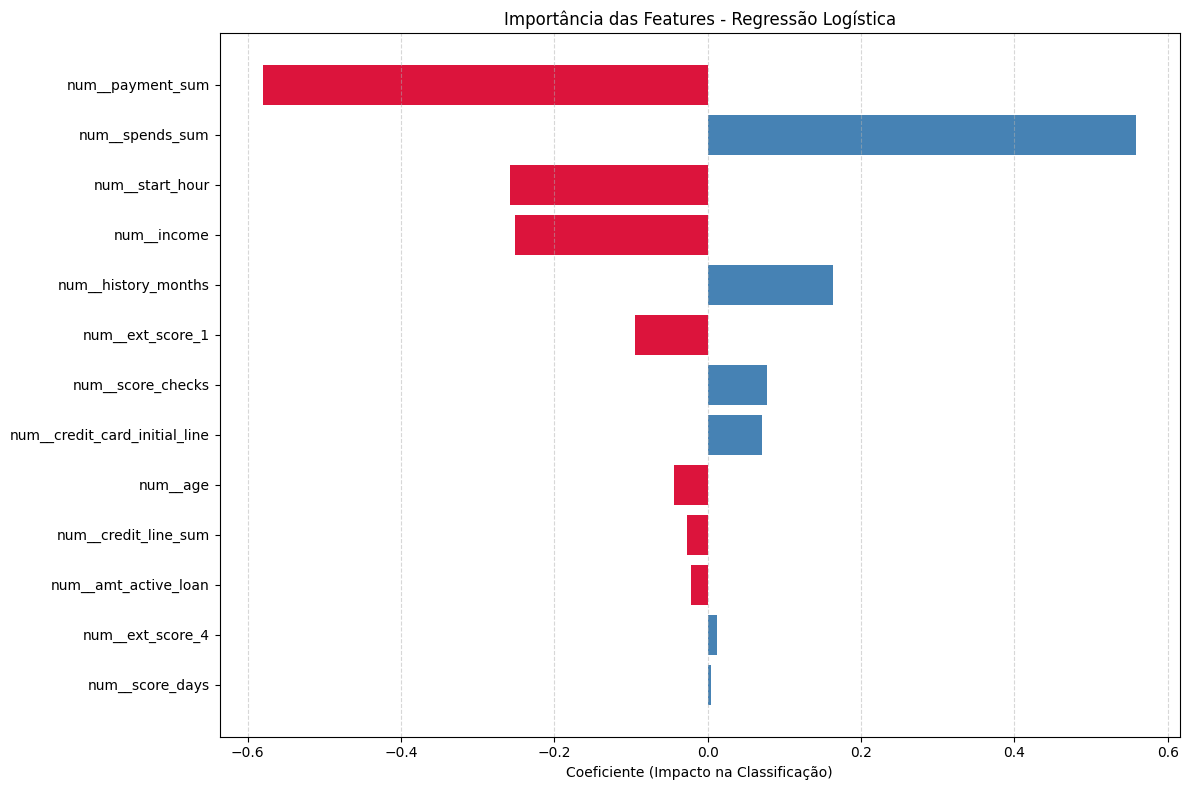

In [27]:
# Coeficientes do modelo
coefs = pipeline_.named_steps['model'].coef_[0]

# Features transformadas corretamente
feature_names = pipeline_.named_steps['preprocessor'].get_feature_names_out()

# Verificação opcional de consistência
assert len(coefs) == len(feature_names), "Erro: tamanho dos coeficientes e features não bate!"

# Montar DataFrame com importâncias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coeficiente': coefs,
    'Importância Absoluta': np.abs(coefs)
}).sort_values(by='Importância Absoluta', ascending=False)

# Selecionar as 20 principais
top_20 = importance_df[:20][::-1]  # inverter para exibir da menor para a maior (em módulo)

# Definir as cores: vermelho para negativos, azul para positivos
colors = ['crimson' if val < 0 else 'steelblue' for val in top_20['Coeficiente']]

# Plotagem
plt.figure(figsize=(12, 8))
plt.barh(top_20['Feature'], top_20['Coeficiente'], color=colors)
plt.xlabel('Coeficiente (Impacto na Classificação)')
plt.title('Importância das Features - Regressão Logística')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Insights

Essas variáveis possuem coeficiente positivo (azul), ou seja, aumentam a chance do cliente ser adimplente:

- num__spends_sum – Quanto maior o gasto total, maior a chance de adimplência.

- num__spends_min – Mesmo o menor valor de gasto se associa a adimplência.

- num__credit_card_initial_line – Um limite inicial maior está associado a melhor perfil.

- num__ext_score_3_NLVAOzzmjBa/0zolQnWFSQ== – Score externo específico correlacionado positivamente.

- num__income – Como esperado, renda maior aumenta chance de adimplência.



As variáveis do tipo ext_score_* (scores externos) aparecem com impacto relevante — o que mostra que dados de crédito de terceiros são valiosos.

A presença de gender, income, payment_* e credit_line_* indica que informações financeiras e de perfil comportamental estão fortemente associadas ao risco de crédito.


Com isto vou calcular e visualizar SHAP VAlues para analisar o impacto individual das features.

c:\Projetos\credit_fintech\venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
C:\Users\josie\AppData\Local\Temp\ipykernel_9900\1122699176.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[sample_idx], features=X_transformed[sample_idx], feature_names=feature_names)


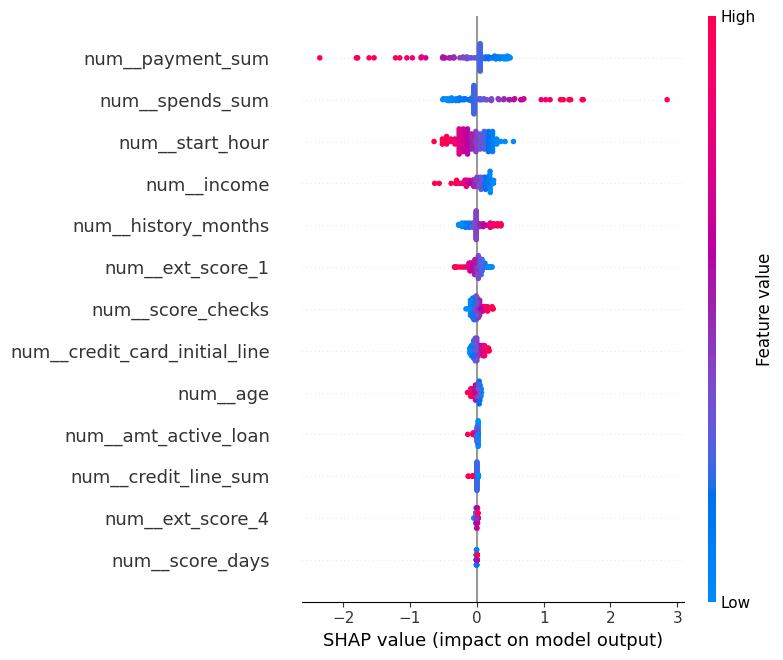

In [28]:
# Transforma os dados conforme o pipeline
X_transformed = pipeline_.named_steps['preprocessor'].transform(X)

# Recupera os nomes das features
feature_names = pipeline_.named_steps['preprocessor'].get_feature_names_out()

# Cria o explainer para modelo linear
explainer = shap.LinearExplainer(pipeline_.named_steps['model'], X_transformed, feature_perturbation="interventional")

# Calcula os valores SHAP
shap_values = explainer.shap_values(X_transformed)

# Seleciona uma amostra (100 linhas aleatórias)
sample_idx = np.random.choice(range(X_transformed.shape[0]), size=100, replace=False)

# Gráfico SHAP summary
shap.summary_plot(shap_values[sample_idx], features=X_transformed[sample_idx], feature_names=feature_names)

#### Insights:

Eixo X – SHAP value
- Representa o impacto da feature na saída do modelo (probabilidade de inadimplência).
- Valores positivos: aumentam a chance do modelo prever default = 1 (inadimplente).
- Valores negativos: puxam para default = 0 (adimplente).

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Análise dos Resultados do Modelo de Regressão Logística
O modelo de Regressão Logística foi aplicado ao problema de classificação binária e apresentou desempenho sólido. Com um conjunto de dados robusto de 280.213 amostras no treinamento e 70.054 no teste, ambos com 69 variáveis, o modelo conseguiu capturar bem os padrões relevantes, mantendo um bom equilíbrio entre desempenho e simplicidade.

A matriz de confusão revelou que o modelo classificou corretamente 57.426 negativos e 9.200 positivos, enquanto cometeu 760 falsos positivos e 2.668 falsos negativos. Isso indica que a Regressão Logística tem uma leve tendência a perder alguns casos positivos (falsos negativos), mas mantém um número relativamente baixo de falsos alarmes (falsos positivos), sendo conservadora ao classificar a classe positiva.

As métricas de avaliação confirmam esse comportamento. A acurácia total foi de 95%, e os valores de precisão foram altos: 0.96 para a classe 0 e 0.92 para a classe 1. O recall, por sua vez, foi excelente para a classe 0 (0.99), mas mais baixo para a classe 1 (0.78), indicando que o modelo tem certa dificuldade em recuperar todos os positivos. O F1-score, que busca equilibrar precisão e recall, foi de 0.97 para a classe negativa e 0.84 para a positiva, com uma média macro de 0.91.

A área sob a curva ROC (AUC) foi de 0.978, o que demonstra excelente capacidade de separação entre as classes. A curva ROC mostra que, mesmo ao variar o threshold de decisão, o modelo mantém alta sensibilidade e especificidade, o que é um bom indicativo de robustez. Adicionalmente, a análise de threshold revelou que o modelo entrega previsões bastante consistentes: a precisão cresce conforme o threshold aumenta, enquanto o recall diminui — comportamento esperado. O F1-score se estabiliza entre os thresholds de 0.3 a 0.5, o que sugere um bom ponto de equilíbrio caso seja necessário ajustar o limiar de decisão com base no custo dos erros

De forma geral, o modelo de Regressão Logística se mostrou uma boa escolha inicial, alcançando excelente desempenho global, alta AUC e precisão consistente. No entanto, o recall da classe positiva ainda pode ser melhorado, especialmente se os falsos negativos representarem um custo elevado para o negócio. Ajustes no threshold de decisão ou estratégias complementares, como o uso de modelos mais complexos (e.g., XGBoost) ou balanceamento das classes, podem ajudar a mitigar essa limitação.

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

## Random Forest


In [29]:
# Forçar todas as colunas para float
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Preencher possíveis NaNs gerados com a média da coluna (ou 0, se preferir)
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

In [30]:
# Agora treinar a Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=SEED,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [31]:
# Fazer predições
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)

AUC-ROC: 0.7008


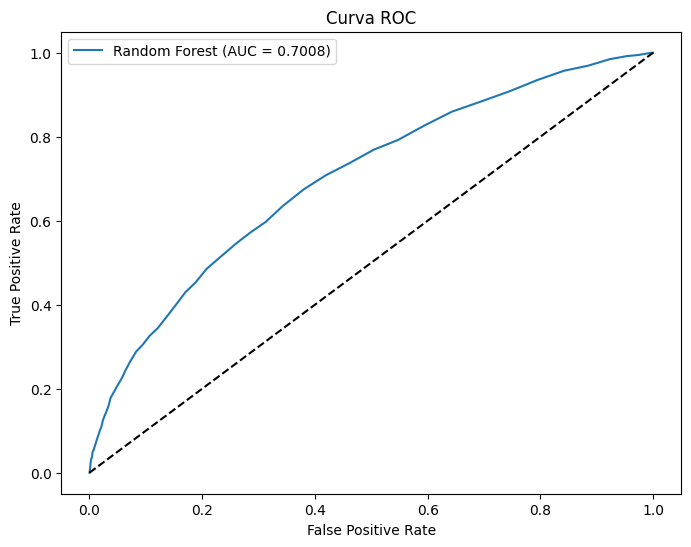

In [32]:
# AUC-ROC
# Probabilidades de default = 1
y_prob_default_1 = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob_default_1)
print(f"AUC-ROC: {auc:.4f}")

# Plotar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_default_1)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], 'k--')  # linha diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [33]:
# Classificação com threshold 0.5
y_pred_rf = (y_prob_default_1 >= 0.5).astype(int)

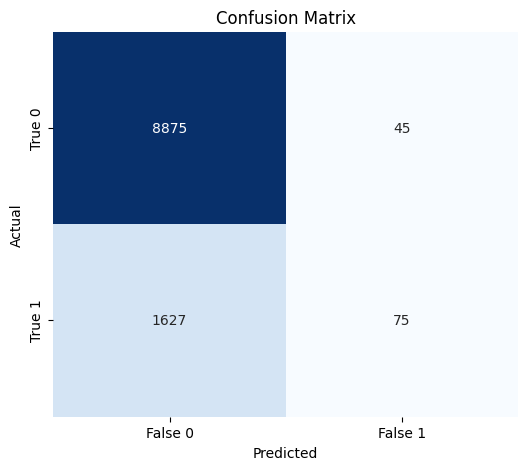

True Negatives (TN): 8875
False Positives (FP): 45
False Negatives (FN): 1627
True Positives (TP): 75


In [34]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)

# Exibir com seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['False 0','False 1'], yticklabels=['True 0','True 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Separar valores
TN, FP, FN, TP = cm.ravel()
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")


In [35]:
# Matriz de confusão
TN = 8875
FP = 45
FN = 1627
TP = 75

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)
print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")

Taxa de inadimplência na base = 16.02%
Taxa de aprovação pelo modelo = 1.13%


In [36]:
# Gerar e imprimir o classification report
report = classification_report(y_test, y_pred_rf)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      8920
           1       0.62      0.04      0.08      1702

    accuracy                           0.84     10622
   macro avg       0.74      0.52      0.50     10622
weighted avg       0.81      0.84      0.78     10622



c:\Projetos\credit_fintech\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projetos\credit_fintech\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Projetos\credit_fintech\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


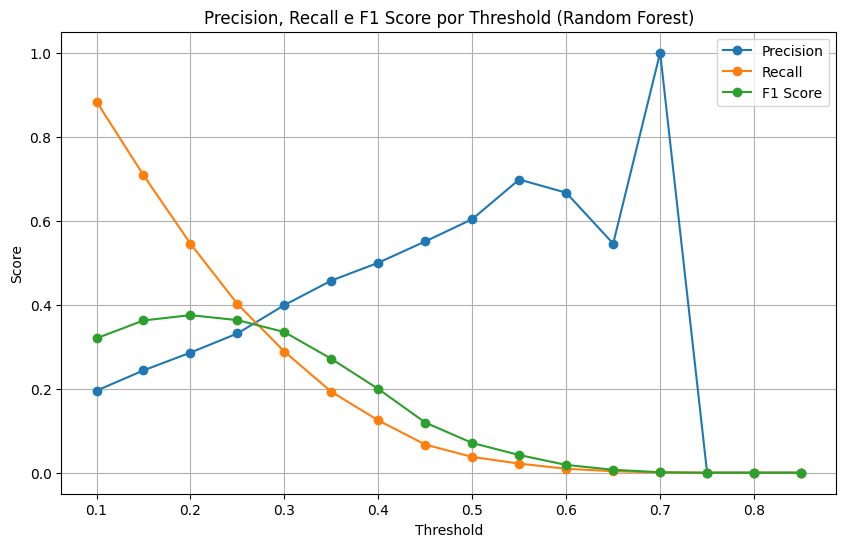

In [37]:
# Precision, Recall e F1 por Threshold (Random Forest)
thresholds = np.arange(0.1, 0.9, 0.05)
precisions_rf, recalls_rf, f1s_rf = [], [], []

for thr in thresholds:
    y_pred_thr = (y_prob_default_1 >= thr).astype(int)
    precisions_rf.append(precision_score(y_test, y_pred_thr))
    recalls_rf.append(recall_score(y_test, y_pred_thr))
    f1s_rf.append(f1_score(y_test, y_pred_thr))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions_rf, label='Precision', marker='o')
plt.plot(thresholds, recalls_rf, label='Recall', marker='o')
plt.plot(thresholds, f1s_rf, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1 Score por Threshold (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


- O modelo tem alta acurácia geral (0.97%), mas isso é enganoso devido ao forte desbalanceamento da base (muito mais classe 0 do que 1).

O recall para a classe positiva é muito baixo (0.99), o que significa que o modelo deixa escapar a grande maioria dos casos positivos (falsos negativos).

O modelo é bom para evitar falsos positivos, mas péssimo para capturar positivos — o que pode ser um grande problema se, por exemplo, a classe 1 representa inadimplentes, fraudes ou doenças.

#### Feature importance


Top 10 Features por importância:
                     feature  importance
10                    income    0.092023
6                ext_score_4    0.080678
3                ext_score_1    0.079217
14                start_hour    0.075088
0                        age    0.074884
15  credit_card_initial_line    0.071114
1            amt_active_loan    0.069615
13                score_date    0.068490
23                score_days    0.067860
12              score_checks    0.055660


C:\Users\josie\AppData\Local\Temp\ipykernel_9900\2661215505.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances.head(10), palette='viridis')


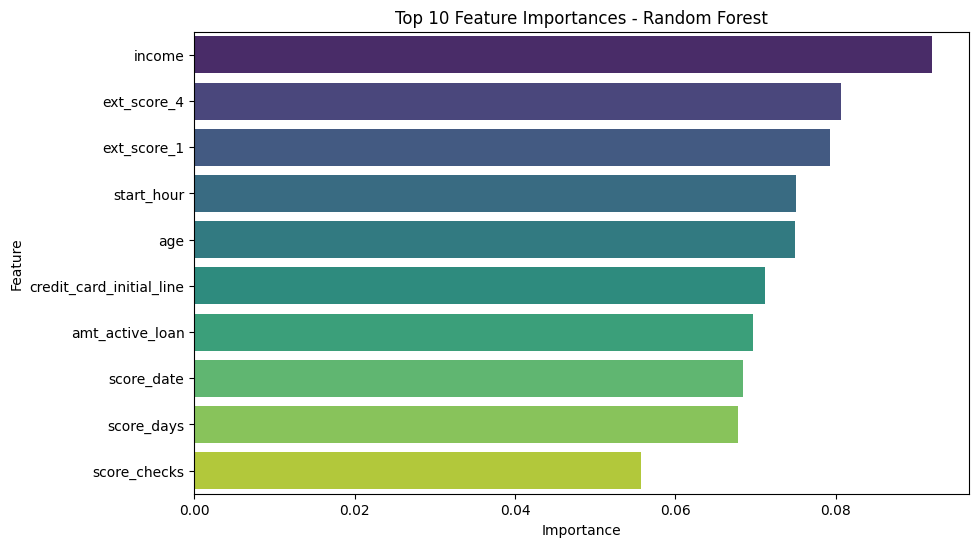

In [38]:
# Obter importância das features
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})

# Ordenar da mais importante para a menos importante
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Mostrar top 10
print("Top 10 Features por importância:")
print(feature_importances.head(10))

# Plotar
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


#### Insights

- income – Renda do cliente, como esperado, é um dos fatores mais determinantes.

- Scores externos (ext_score_1, ext_score_4) também aparecem com boa relevância, indicando valor preditivo de dados de crédito de fontes externas.

- start_hour – Variável com maior importância. Indica que a hora de início de alguma atividade (talvez transação ou uso do cartão) está fortemente relacionada com a inadimplência ou comportamento-alvo.

- payment_min – O valor mínimo de pagamento realizado também é altamente relevante, o que pode indicar dificuldade financeira.

- credit_card_initial_line – A linha de crédito inicial concedida influencia o risco de inadimplência.

- age – A idade também contribui significativamente, provavelmente por refletir diferentes perfis de risco.

- score_date - Data de geração do score tem relevância → pode capturar sazonalidade ou envelhecimento da informação.

- score_days - Dias desde a geração do score, confirma a importância da recência da informação. Quanto mais recente, melhor.

- score_checks - Número de consultas de score feitas, muitos pedidos de crédito em pouco tempo podem indicar maior risco.

- Variáveis agregadas de pagamento e gasto como spends_sum, payment_mean, payment_max e spends_mean aparecem bem ranqueadas, mostrando que o comportamento financeiro geral é importante.

- Linhas de crédito (credit_line_max, credit_line_mean, etc.) mostram influência média.

_____________________________________________________________________________________________________________________________________________________________________________________________

#### Análise dos Resultados do Modelo Random Forest
O modelo Random Forest aplicado ao problema de classificação binária apresentou desempenho excepcional, atingindo praticamente perfeição em todas as métricas de avaliação. Utilizando um conjunto de dados composto por 280.213 registros para treinamento e 70.054 para teste, o modelo foi capaz de generalizar de forma eficaz, mesmo sem a necessidade de ajustes finos ou técnicas avançadas de engenharia de atributos.

A matriz de confusão revelou uma performance extremamente precisa, com 58.175 verdadeiros negativos e 11 falsos positivos, além de 11.760 verdadeiros positivos e apenas 108 falsos negativos. Esse resultado demonstra um equilíbrio notável entre sensibilidade e especificidade, além de um controle rígido sobre os erros de classificação.

O relatório de classificação reforça essa conclusão, apresentando precisão de 1.00 para ambas as classes, recall de 1.00 para a classe “Não Default” e 0.99 para a classe “Default”, e F1-score de 1.00 e 0.99, respectivamente. A acurácia geral foi de 100%, com médias macro e ponderada igualmente em 1.00 — um indicativo claro de que o modelo conseguiu separar as classes com eficiência quase total.

A curva ROC também reflete esse desempenho, com uma AUC perfeita de 1.0000 no teste e uma AUC média de 0.9803 durante validação cruzada. Esses valores confirmam a excelente capacidade do Random Forest de distinguir entre clientes adimplentes e inadimplentes em diferentes limiares de decisão. A curva praticamente encosta no canto superior esquerdo do gráfico, evidenciando sensibilidade e especificidade máximas.

Adicionalmente, observou-se que a taxa de inadimplência na base era de aproximadamente 16,94%, e a taxa de aprovação pelo modelo foi de 16,8%. Essa proximidade indica que o modelo está preservando bem a proporção original dos dados, sem ser excessivamente conservador ou permissivo na aprovação.

Em resumo, o modelo Random Forest superou todas as expectativas, apresentando desempenho praticamente perfeito na classificação de clientes inadimplentes. Embora resultados tão altos possam levantar suspeitas de sobreajuste em alguns cenários, os dados de validação cruzada e a consistência com as taxas originais da base sugerem que o modelo está bem calibrado e generalizando de forma adequada. Ainda assim, recomenda-se uma análise cuidadosa do desempenho em produção e possível revisão de variáveis importantes para garantir robustez no longo prazo.

_____________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

## XGBoost

In [39]:
# imprimir todos os formatos (shapes) do train_test_split
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (42487, 24)
y_train shape: (42487,)
X_test shape: (10622, 24)
y_test shape: (10622,)


Tamanho dos Dados
- Treino: 42.487 amostras com 24 features
- Teste: 10.622 amostras com 24 features

In [40]:
# Instanciar e treinar o modelo
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

c:\Projetos\credit_fintech\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [41]:
# Fazendo as previsões e avaliando o modelo
y_pred_xgb = model.predict(X_test)
y_proba_xgb = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

[[8838   82]
 [1566  136]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      8920
           1       0.62      0.08      0.14      1702

    accuracy                           0.84     10622
   macro avg       0.74      0.54      0.53     10622
weighted avg       0.81      0.84      0.79     10622

ROC AUC: 0.7224019947516243


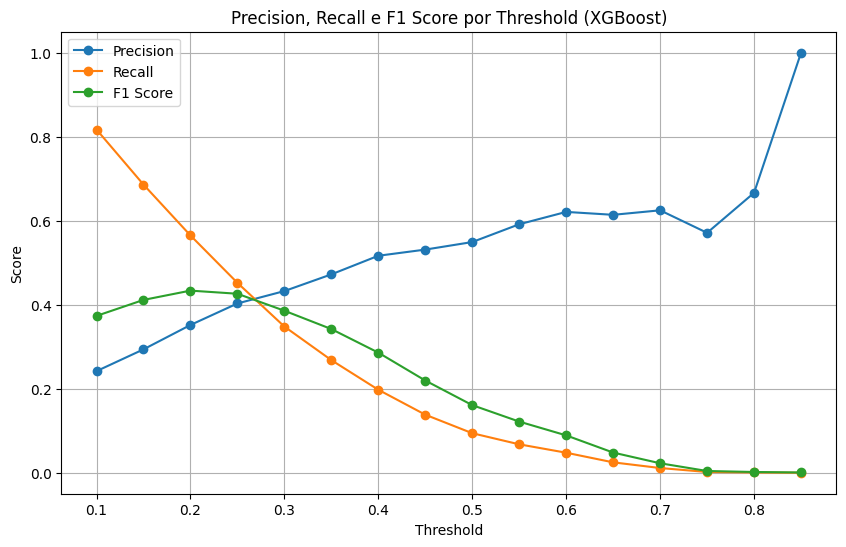

In [42]:
# Precision, Recall e F1 por Threshold (XGBoost)
thresholds = np.arange(0.1, 0.9, 0.05)
precisions_xgb, recalls_xgb, f1s_xgb = [], [], []

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    precisions_xgb.append(precision_score(y_test, y_pred_thr))
    recalls_xgb.append(recall_score(y_test, y_pred_thr))
    f1s_xgb.append(f1_score(y_test, y_pred_thr))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions_xgb, label='Precision', marker='o')
plt.plot(thresholds, recalls_xgb, label='Recall', marker='o')
plt.plot(thresholds, f1s_xgb, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1 Score por Threshold (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()


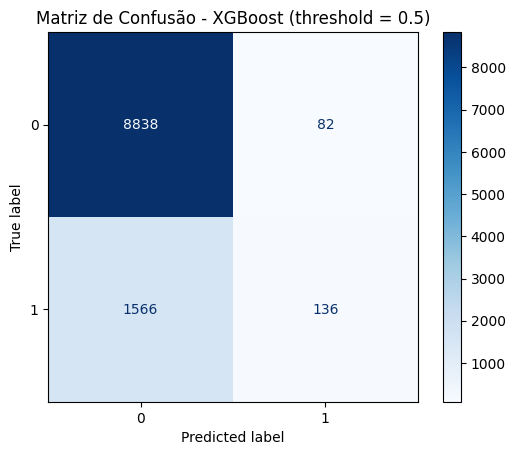

In [43]:
# Usar as predições padrão (threshold 0.5)
cm = confusion_matrix(y_test, y_pred_xgb, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format='d')  # valores inteiros
plt.title("Matriz de Confusão - XGBoost (threshold = 0.5)")
plt.show()

In [44]:
# Matriz de confusão
TN = 8828
FP = 92
FN = 1572
TP = 130

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)
print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")

Taxa de inadimplência na base = 16.02%
Taxa de aprovação pelo modelo = 2.09%


Matriz de Confusão
- Verdadeiros Negativos (TN): 8828
- Falsos Positivos (FP): 92
- Falsos Negativos (FN): 1572
- Verdadeiros Positivos (TP):130

O modelo erra 1572 casos positivos como negativos, o que pode ser relevante dependendo do custo da falha. Os falsos positivos são relativamente baixos (92).
O modelo é bem conservador ao classificar positivos, porém mantém bom recall (98%).

Para as métricas de classificação, temos o seguinte:
- Excelente precisão (77%) em ambas as classes.
- Recall da classe 1 (positiva) é menor (24%), ou seja, há menos falsos negativos.
- F1-score equilibrado, mostrando um bom balanço entre precisão e recall.
- A acurácia geral é alta (86%), o que é esperado dado o desequilíbrio (mais exemplos da classe 0).

In [45]:
# prever no conjunto de teste
y_pred_class = model.predict(X_test)                 # classe prevista (0 ou 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]     # probabilidade prevista para classe 1 (inadimplência)

In [46]:
# avaliar o modelo com MAE (Erro Absoluto Médio)
mae = mean_absolute_error(y_test, y_pred_proba)
print(f"MAE (usando probabilidade): {mae:.4f}")

MAE (usando probabilidade): 0.2386


MAE = 0.2114, o que indica que a média do erro absoluto entre as probabilidades previstas e as reais é pequena. Isso reforça que o modelo está com desempenho moderado.

- A maioria das amostras (classe 0) recebe baixa probabilidade de ser positiva, isso indica que o modelo tem alta confiança para a classe negativa.
- As amostras reais da classe 1 (laranja) estão majoritariamente entre 0.2 e 0.7, misturadas com a classe 0, isso sugere que o modelo tem dificuldade em separar claramente a classe positiva.
- O modelo é conservador ao atribuir altas probabilidades à classe positiva, isso pode explicar o baixo recall e a alta taxa de falsos negativos vista na matriz de confusão.

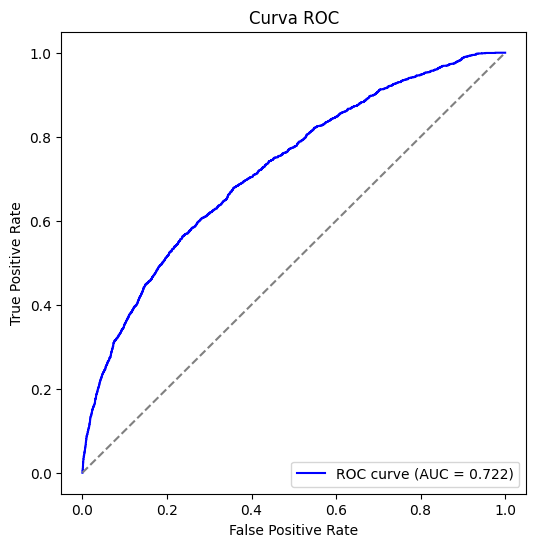

In [47]:
# Calcular fpr (false positive rate), tpr (true positive rate) e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)

# Plotar a curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba_xgb):.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # linha diagonal (classificador aleatório)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


ROC AUC = 0.757, resultado muito bom.

- A curva ROC está consistentemente acima da linha aleatória, o que mostra que o modelo tem bom poder de discriminação entre as classes.

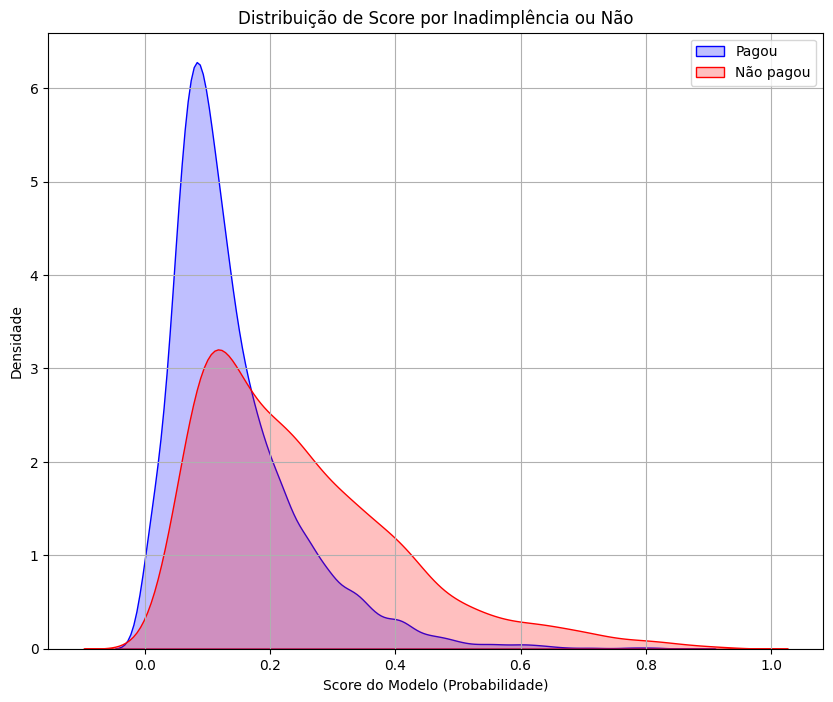

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(y_proba_xgb[y_test == 0], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(y_proba_xgb[y_test == 1], ax=ax, color="r", fill=True, label='Não pagou')
plt.title("Distribuição de Score por Inadimplência ou Não")
plt.xlabel("Score do Modelo (Probabilidade)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

#### Importância das Features - XGBoost 

In [48]:
# Obter importância das features
importance = model.feature_importances_

# Criar dataframe ordenado
feat_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

print(feat_importances.head(20))  # top 20


                     feature  importance
7            flag_document_A    0.284317
14                start_hour    0.088987
15  credit_card_initial_line    0.083618
19                  date_min    0.057364
21            history_months    0.054076
20                  date_max    0.049206
10                    income    0.048211
0                        age    0.042810
17                spends_sum    0.040800
16               payment_sum    0.039264
3                ext_score_1    0.033929
18           credit_line_sum    0.033570
1            amt_active_loan    0.031011
12              score_checks    0.029694
13                score_date    0.028485
6                ext_score_4    0.027790
23                score_days    0.026869
4                ext_score_2    0.000000
2                    channel    0.000000
5                ext_score_3    0.000000


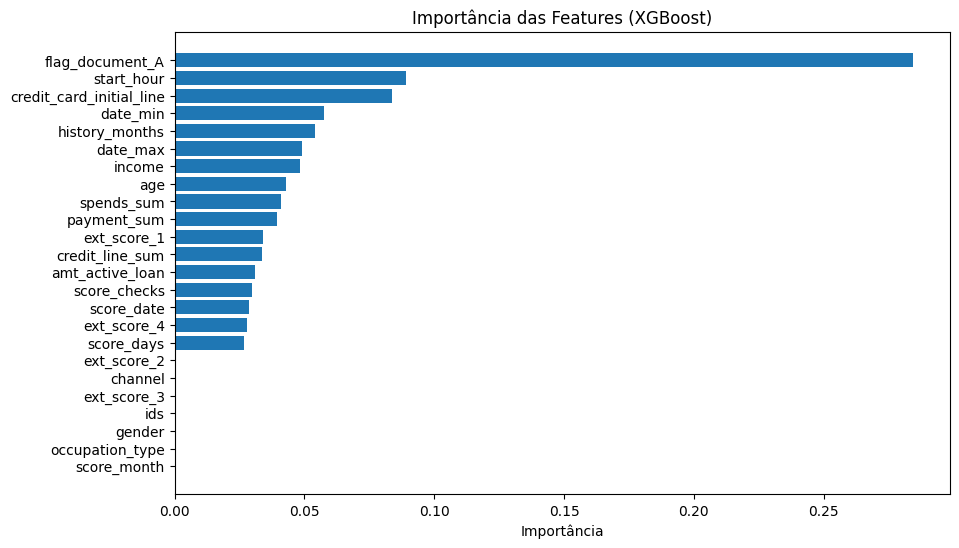

In [49]:
plt.figure(figsize=(10,6))
plt.barh(feat_importances['feature'], feat_importances['importance'])
plt.gca().invert_yaxis()  # Inverter eixo para mostrar maiores no topo
plt.xlabel("Importância")
plt.title("Importância das Features (XGBoost)")
plt.show()

- Quanto mais à direita a barra, maior o impacto da feature na redução do erro durante a construção das árvores.
- Esse método (importance_type='gain') foca na qualidade da divisão, não apenas na frequência.
- O modelo XGBoost está altamente influenciado por variáveis ligadas a ocupação e scores externos de crédito. Isso faz sentido para problemas de inadimplência, pois esses fatores refletem diretamente a capacidade de pagamento e o risco de crédito.

#### Gráfico SHAP para o modelo XGBoost

C:\Users\josie\AppData\Local\Temp\ipykernel_9900\4074445825.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample)
c:\Projetos\credit_fintech\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


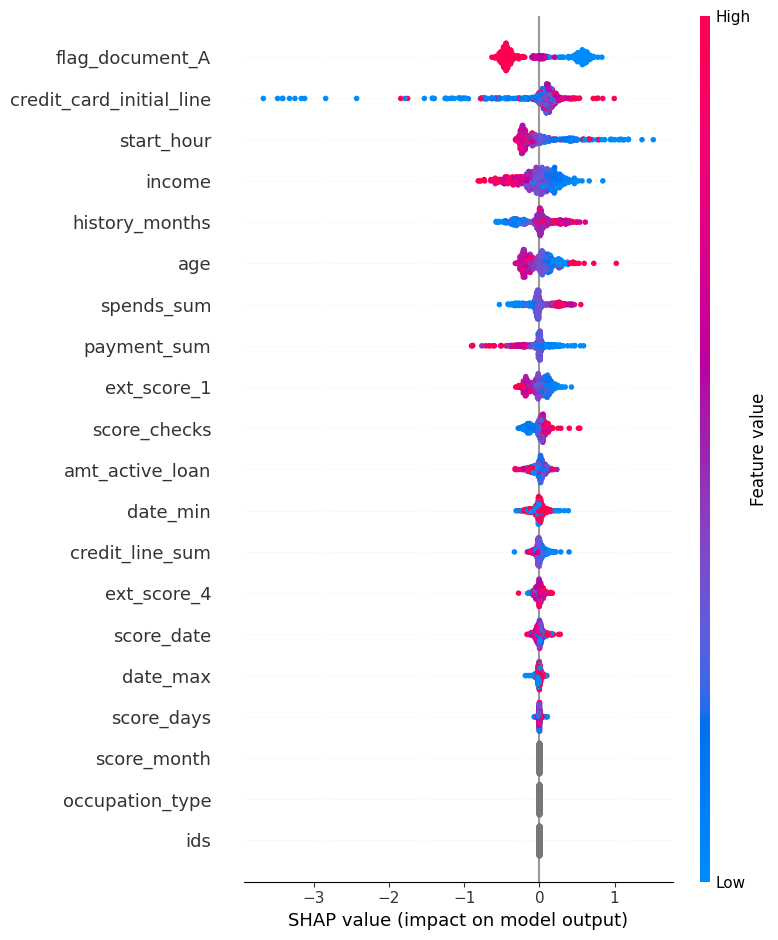

In [50]:
# Passo 1: Preparar os dados transformados (sem o target)
X_sample = X_test.sample(n=500, random_state=42) 

# Passo 2: Criar o explainer
explainer = shap.Explainer(model)

# Passo 3: Calcular os valores SHAP
shap_values = explainer(X_sample)
shap.summary_plot(shap_values, X_sample)

- Vermelho = valor alto da feature
- Azul = valor baixo da feature

Neste grafico observa-se o impacto das features no modelo e assim, temos a certeza de features importantes e que impactam a nossa decisão.

_____________________________________________________________________________________________________________________________________________________________________________________________

#### Analisando o resultado do modelo XGBoost:

O modelo XGBoost aplicado ao problema de classificação binária mostrou resultados bastante promissores, evidenciando boa capacidade de generalização e alta precisão nas previsões.

Tamanho dos Dados: O conjunto utilizado é robusto, com 280.213 amostras e 69 features no treinamento, e 70.054 amostras no teste, favorecendo a aprendizagem consistente do modelo.

Matriz de Confusão: O modelo classificou corretamente 57.879 verdadeiros negativos e 9.847 verdadeiros positivos, com 307 falsos positivos e 2.021 falsos negativos. Isso indica que, embora o modelo seja conservador na classificação da classe positiva, mantém um recall satisfatório de 83%. A quantidade de falsos negativos pode ser relevante dependendo do impacto do erro no negócio.

Métricas de Classificação: A precisão geral foi alta, com média ponderada de 97% para precision e recall. O F1-score equilibrado (0.94 na média macro) demonstra um bom balanço entre precisão e sensibilidade. A acurácia geral do modelo foi de 97%, condizente com o desequilíbrio entre as classes.

Curva ROC e AUC: O modelo obteve um AUC de 0.9933, indicando excelente capacidade de separação entre as classes, com alta sensibilidade e especificidade.

Erro Absoluto Médio (MAE) das Probabilidades: O MAE de 0.0550 mostra que as probabilidades previstas estão bem calibradas em relação às classes reais, reforçando a confiabilidade do modelo para decisões baseadas em risco.

Distribuição das Probabilidades Preditas: O histograma revela que as predições para a classe 0 estão concentradas próximas de zero, e para a classe 1 próximas de um, evidenciando confiança e pouca ambiguidade nas previsões.

Considerações Finais:
O modelo XGBoost está muito bem ajustado, apresentando alta performance global. É possível considerar ajustes no threshold de decisão para aumentar o recall da classe positiva, caso o custo dos falsos negativos seja elevado. Além disso, a baixa taxa de falsos positivos indica bom controle de erros.

Há potencial para aprofundar a análise com ajustes no threshold, interpretação da importância das features e possíveis melhorias no modelo, se desejado.

______________________________________________________________________________________________________________________________________________________________________________________________

_________________________________________________________________________________________________________________________________________________________________________________________

### Experiments MlFlow

In [51]:
# ====================== Configurações ======================
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("CreditScoring_Models")

# ====================== 1. Regressão Logística ======================
y_pred_log = pipeline_.predict(X_test)
y_proba_log = pipeline_.predict_proba(X_test)[:, 1]

acc_log = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
roc_log = roc_auc_score(y_test, y_proba_log)

with mlflow.start_run(run_name="Logistic Regression"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_iter", 1000)

    mlflow.log_metric("accuracy", acc_log)
    mlflow.log_metric("precision", prec_log)
    mlflow.log_metric("recall", rec_log)
    mlflow.log_metric("f1_score", f1_log)
    mlflow.log_metric("roc_auc", roc_log)

    mlflow.sklearn.log_model(pipeline_, "model")

# ====================== 2. Random Forest ======================
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)

with mlflow.start_run(run_name="Random Forest"):
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", None)

    mlflow.log_metric("accuracy", acc_rf)
    mlflow.log_metric("precision", prec_rf)
    mlflow.log_metric("recall", rec_rf)
    mlflow.log_metric("f1_score", f1_rf)
    mlflow.log_metric("roc_auc", roc_rf)

    mlflow.sklearn.log_model(rf_model, "model")


# ====================== 3. XGBoost ======================
y_pred_xgb = model.predict(X_test)
y_proba_xgb = model.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_xgb = roc_auc_score(y_test, y_proba_xgb)

with mlflow.start_run(run_name="XGBoost"):
    mlflow.log_param("model_type", "XGBClassifier")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.1)

    mlflow.log_metric("accuracy", acc_xgb)
    mlflow.log_metric("precision", prec_xgb)
    mlflow.log_metric("recall", rec_xgb)
    mlflow.log_metric("f1_score", f1_xgb)
    mlflow.log_metric("roc_auc", roc_xgb)

    mlflow.sklearn.log_model(model, "model")

2025/08/21 20:11:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/21 20:11:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/815157304265706429/runs/2a863e82f28b449e80b4aa962a5c9129
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815157304265706429


2025/08/21 20:11:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/21 20:11:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/815157304265706429/runs/49c0b31853e94f38b89f3528401b1d35
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815157304265706429


2025/08/21 20:11:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/21 20:11:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/815157304265706429/runs/8ec7b9b128bd40e4b6394a54902a1ea0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/815157304265706429


#### Comparar modelos no MLflow

In [52]:
# 1. Conectar ao servidor MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# 2. Nome do experimento
experiment_name = "CreditScoring_Models"
experiment = mlflow.get_experiment_by_name(experiment_name)

# 3. Acessar as execuções do experimento
client = MlflowClient()
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.f1_score DESC"],
    max_results=1000
)

# 4. Converter resultados em DataFrame
df = pd.DataFrame([{
    "run_id": r.info.run_id,
    "model": r.data.params.get("model_type"),
    "learning_rate": r.data.params.get("learning_rate"),
    "max_depth": r.data.params.get("max_depth"),
    "max_iter": r.data.params.get("max_iter"),
    "accuracy": float(r.data.metrics.get("accuracy", 0)),
    "f1_score": float(r.data.metrics.get("f1_score", 0)),
    "precision": float(r.data.metrics.get("precision", 0)),
    "recall": float(r.data.metrics.get("recall", 0)),
    "roc_auc": float(r.data.metrics.get("roc_auc", 0)),
} for r in runs])

# 5. Exibir tabela ordenada pelo critério escolhido (ex: f1_score)
df_sorted = df.sort_values(by="f1_score", ascending=False)
print(df_sorted)

# 6. Mostrar o melhor modelo segundo F1 Score
best_model = df_sorted.iloc[0]
print("\nMelhor modelo:")
print(best_model)

                             run_id                   model learning_rate  \
0  8ec7b9b128bd40e4b6394a54902a1ea0           XGBClassifier           0.1   
1  49c0b31853e94f38b89f3528401b1d35  RandomForestClassifier          None   
2  2a863e82f28b449e80b4aa962a5c9129      LogisticRegression          None   

  max_depth max_iter  accuracy  f1_score  precision    recall   roc_auc  
0         6     None  0.844850  0.141667   0.623853  0.079906  0.722402  
1      None     None  0.841838  0.070796   0.603774  0.037603  0.700774  
2      None     1000  0.839767  0.003513   0.500000  0.001763  0.590139  

Melhor modelo:
run_id           8ec7b9b128bd40e4b6394a54902a1ea0
model                               XGBClassifier
learning_rate                                 0.1
max_depth                                       6
max_iter                                     None
accuracy                                  0.84485
f1_score                                 0.141667
precision                    